### Resultados simulaciones

Se revisan los resultados con tres tipos de redes: completa, anillo, rejilla.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Se cargan los datos de las simulaciones...

In [39]:
names=['Identificador','Numero_agentes','Tipo_red','Agente','Ronda','Estado','Puntaje','Politica','Parametro-0','Parametro-1','Politica_lag','Consistencia']
df_rejilla = pd.read_csv('data/simulacionesKregular4.csv',names=names,header=None)
df_rejilla['Tipo_red'] = 'rejilla'
df_anillo = pd.read_csv('data/simulacionesKregular2.csv',names=names,header=None)
df_anillo['Tipo_red'] = 'anillo'
df_completa = pd.read_csv('data/simulacionesFull2.csv',names=names,header=None)
data = pd.concat([df_completa, df_anillo, df_rejilla])
data.Tipo_red.value_counts()

rejilla    1133000
Full       1133000
anillo     1133000
Name: Tipo_red, dtype: int64

#### Asistencia óptima

Text(0, 0.5, 'Promedio asistencia óptima\nsobre 100 simulaciones')

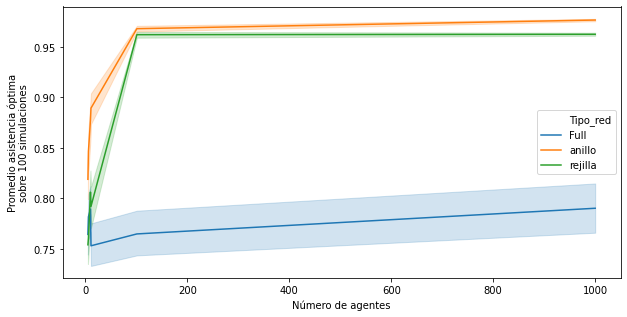

In [26]:
aux = data.groupby(['Tipo_red', 'Numero_agentes', 'Identificador', 'Ronda'])['Estado']\
    .sum().reset_index()
aux.columns = ['Tipo_red',
               'Numero_agentes',
               'Identificador',
               'Ronda', 
               'Asistencia_total']

# Proporción de asistencia
aux['Asistencia'] = aux['Asistencia_total']/aux['Numero_agentes']
# Distancia al cuadrado entre proporción de asistencia y 0.5
aux['diferencia_con_umbral'] = (aux['Asistencia'] - 0.5)*(aux['Asistencia'] - 0.5)
num_rondas = aux.Ronda.max() + 1
df = aux.groupby(['Tipo_red', 'Numero_agentes', 'Identificador'])['diferencia_con_umbral'].sum().reset_index()
df['Asistencia_optima'] = df['diferencia_con_umbral']/num_rondas
df['Asistencia_optima'] = 1 - 2 * np.sqrt(df['Asistencia_optima'])
fig = plt.subplots(figsize=(10,5))
sns.lineplot(x=df['Numero_agentes'], y=df['Asistencia_optima'], hue=df['Tipo_red'])
plt.xlabel('Número de agentes')
plt.ylabel('Promedio asistencia óptima\nsobre 100 simulaciones')

#### Recompensa total

Text(0, 0.5, 'Puntaje promedio sobre\n 100 simulaciones')

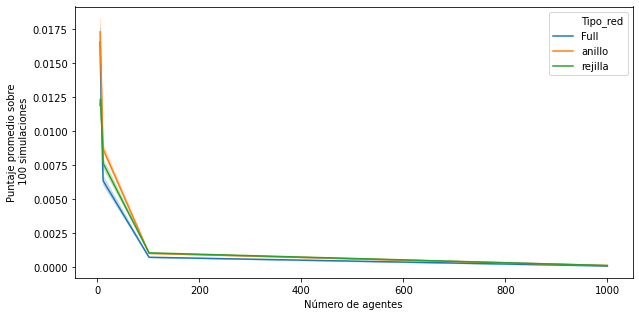

In [38]:
data_aux = data.copy()
data_aux['Puntaje normalizado'] = data_aux['Puntaje'] + 1
data_aux = data_aux.groupby(['Tipo_red', 'Numero_agentes', 'Identificador', 'Agente'])['Puntaje normalizado'].sum().reset_index()
data_aux["Puntaje promedio"]=data_aux["Puntaje normalizado"]/(num_rondas*data_aux["Numero_agentes"])
fig = plt.subplots(figsize=(10,5))
sns.lineplot(
    x=data_aux['Numero_agentes'], 
    y=data_aux['Puntaje promedio'],
    hue=data_aux['Tipo_red']
)
plt.xlabel('Número de agentes')
plt.ylabel('Puntaje promedio sobre\n 100 simulaciones')

#### Distribución de la recompensa

In [31]:
def gini1(x):
    x = np.asarray(x) 
    sorted_x = np.sort(x) 
    n = len(x) 
    cumx = np.cumsum(sorted_x, dtype=float)
    try:
        gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    except:
        gini = 0
    return np.round(gini,3)

<ipython-input-31-4d0745773ace>:7: RuntimeWarning: invalid value encountered in double_scalars
  gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n


Text(0, 0.5, 'Índice de Gini')

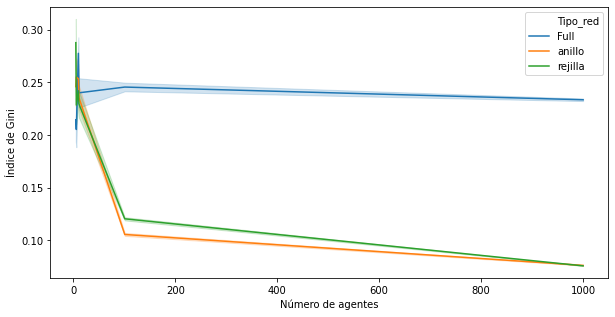

In [33]:
data_aux['Gini'] = data_aux.groupby(['Numero_agentes','Identificador'])['Puntaje normalizado'].transform(func = gini1)
fig = plt.subplots(figsize=(10,5))
sns.lineplot(
    x=data_aux['Numero_agentes'], 
    y=data_aux['Gini'],
    hue=data_aux['Tipo_red']
)
plt.xlabel('Número de agentes')
plt.ylabel('Índice de Gini')

**Fijar un número de agentes**

In [68]:
NA = data.Numero_agentes.unique().tolist()
NA

[5, 6, 10, 11, 101, 1000]

In [70]:
N = NA[0]
df = data[data['Numero_agentes']==N]
df = pd.DataFrame(df.groupby(['Tipo_red', 'Identificador', 'Ronda','Politica'])['Agente'].count()).reset_index()
df.columns = ['Tipo_red', 'Identificador', 'Ronda','Politica', 'cantidad_agentes']
df = df.groupby(['Tipo_red', 'Ronda','Politica'])['cantidad_agentes'].mean().reset_index()
df.head(2)

,Tipo_red,Ronda,Politica,cantidad_agentes
0,Full,0,0,1.166667
1,Full,0,1,1.369565


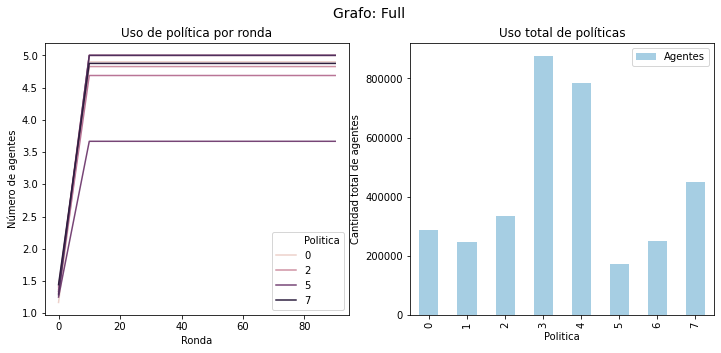

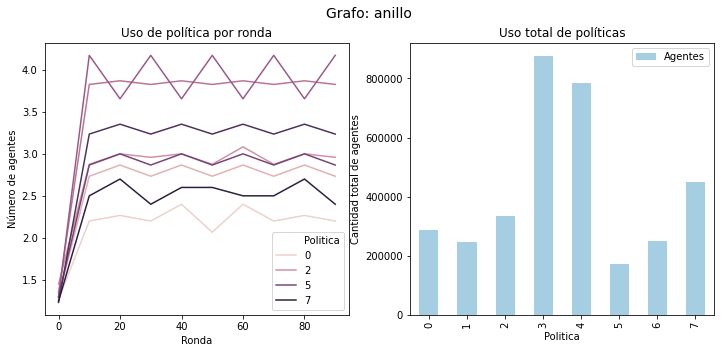

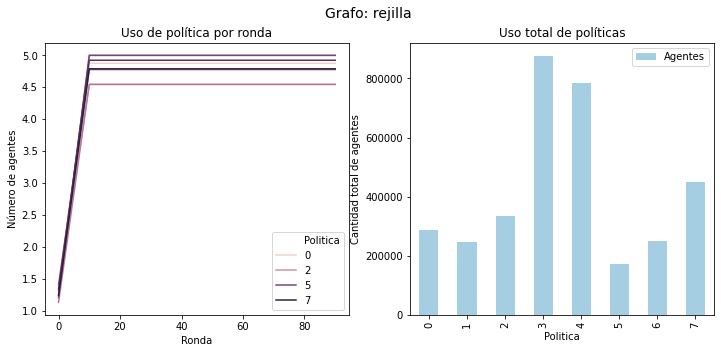

In [73]:
sns.set_palette("Paired")
for r, grp in df.groupby('Tipo_red'):
    fig, ax = plt.subplots(1,2,figsize = (12,5))
    sns.lineplot(
                x=grp['Ronda'], 
                y=grp['cantidad_agentes'],
                hue=grp['Politica'],
                ax=ax[0]
            )
    #for label, group in grp.groupby('Politica'):
    #    group.plot(x='Ronda', y='cantidad_agentes', ax=ax[0],label=label)
    #ax[0].set_ylim([0,Num_agentes+1])
    ax[0].set_title('Uso de política por ronda')
    ax[0].set_ylabel('Número de agentes')
    df1 = pd.DataFrame(data.groupby('Politica')['Agente'].count())
    df1.columns = ['Agentes']
    #ax[1].plot(df.index, df['Agentes'])
    df1.plot(kind="bar", ax = ax[1])
    ax[1].set_title('Uso total de políticas')
    ax[1].set_ylabel('Cantidad total de agentes')
    fig.suptitle('Grafo: ' + str(r), fontsize=14)